## Описание проекта

### Цель проекта

Компании «Мегалайн» — федеральный оператор сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Нужно сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Описание данных

Таблица users (информация о пользователях):

    user_id — уникальный идентификатор пользователя
    first_name — имя пользователя
    last_name — фамилия пользователя
    age — возраст пользователя (годы)
    reg_date — дата подключения тарифа (день, месяц, год)
    churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    city — город проживания пользователя
    tariff — название тарифного плана

Таблица calls (информация о звонках):

    id — уникальный номер звонка
    call_date — дата звонка
    duration — длительность звонка в минутах
    user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

    id — уникальный номер сообщения
    message_date — дата сообщения
    user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

    id — уникальный номер сессии
    mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    session_date — дата интернет-сессии
    user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

    tariff_name — название тарифа
    rub_monthly_fee — ежемесячная абонентская плата в рублях
    minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    messages_included — количество сообщений в месяц, включённых в абонентскую плату
    mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

### Особенности обработки

1. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
2. Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта. Примите, что неиспользованные за предыдущий месяц звонки, смс, интернет на следующий месяц не переносятся.

## Изучение файла данных

### Открытие файлов

In [1]:
from scipy import stats as st
import numpy as np
import pandas as pd
import math

Импортируем библиотеки, которые нам понадобятся в процессе исследования

Далее будем последовательно открывать каждый из пяти датафреймов и проводить анализ заполнения и наличия ошибок. Первым открываем 'users'.

In [2]:
users = pd.read_csv('')


In [3]:
users.info()
print (users.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB
   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенк

Наименование столбцов корректны. Пропусков в столбцах не видно. Кроме 'churn_date'. Но здесь мы предупреждены при постановке задачи. Заполним пропуски в этом столбце датой 31.12.2018, исходя из того, что контракт действовал, как минимум до конца года.

In [4]:
print(users['churn_date'].unique())

[nan '2018-10-05' '2018-12-18' '2018-11-21' '2018-10-03' '2018-10-14'
 '2018-12-09' '2018-12-11' '2018-12-26' '2018-08-31' '2018-12-03'
 '2018-12-23' '2018-11-07' '2018-12-16' '2018-12-20' '2018-11-30'
 '2018-12-21' '2018-08-17' '2018-09-02' '2018-10-04' '2018-11-13'
 '2018-11-22' '2018-10-28' '2018-11-26' '2018-11-27' '2018-11-16'
 '2018-10-27' '2018-12-30' '2018-09-27' '2018-12-25' '2018-12-14'
 '2018-12-24' '2018-09-26' '2018-10-25']


In [5]:
 print(users['reg_date'].unique())

['2018-05-25' '2018-11-01' '2018-06-17' '2018-08-17' '2018-05-14'
 '2018-01-25' '2018-02-26' '2018-04-19' '2018-12-19' '2018-03-22'
 '2018-08-05' '2018-03-19' '2018-03-28' '2018-11-14' '2018-05-15'
 '2018-04-30' '2018-11-21' '2018-05-22' '2018-04-01' '2018-05-16'
 '2018-10-22' '2018-04-26' '2018-12-01' '2018-10-31' '2018-03-15'
 '2018-10-06' '2018-04-10' '2018-10-02' '2018-09-15' '2018-05-23'
 '2018-11-02' '2018-01-04' '2018-07-15' '2018-08-26' '2018-04-03'
 '2018-07-14' '2018-10-13' '2018-10-07' '2018-06-21' '2018-06-08'
 '2018-11-29' '2018-11-25' '2018-07-08' '2018-05-09' '2018-01-30'
 '2018-08-20' '2018-10-29' '2018-08-19' '2018-03-10' '2018-06-16'
 '2018-05-28' '2018-07-27' '2018-09-30' '2018-03-20' '2018-01-02'
 '2018-04-13' '2018-03-12' '2018-04-14' '2018-11-24' '2018-11-16'
 '2018-04-12' '2018-03-17' '2018-03-08' '2018-06-24' '2018-04-09'
 '2018-07-16' '2018-12-10' '2018-08-07' '2018-01-09' '2018-02-20'
 '2018-10-04' '2018-12-30' '2018-10-23' '2018-06-19' '2018-08-12'
 '2018-03-

По столбцу 'reg_date' видим, что данные корректны, а все контракты были заключены в течение 2018 года.

In [6]:
users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


По столбцу 'age' видим, что данные корректны, аномальных значений не видно.

In [7]:
print(users['city'].sort_values().unique())

['Архангельск' 'Астрахань' 'Балашиха' 'Барнаул' 'Белгород' 'Брянск'
 'Владивосток' 'Владикавказ' 'Владимир' 'Волгоград' 'Волжский' 'Вологда'
 'Воронеж' 'Грозный' 'Екатеринбург' 'Иваново' 'Ижевск' 'Иркутск' 'Казань'
 'Калининград' 'Калуга' 'Кемерово' 'Киров' 'Кострома' 'Краснодар'
 'Красноярск' 'Курган' 'Курск' 'Липецк' 'Магнитогорск' 'Махачкала'
 'Москва' 'Мурманск' 'Набережные Челны' 'Нижневартовск' 'Нижний Новгород'
 'Нижний Тагил' 'Новокузнецк' 'Новороссийск' 'Новосибирск' 'Омск'
 'Оренбург' 'Орёл' 'Пенза' 'Пермь' 'Петрозаводск' 'Подольск'
 'Ростов-на-Дону' 'Рязань' 'Самара' 'Санкт-Петербург' 'Саранск' 'Саратов'
 'Севастополь' 'Смоленск' 'Сочи' 'Ставрополь' 'Стерлитамак' 'Сургут'
 'Тамбов' 'Тверь' 'Тольятти' 'Томск' 'Тула' 'Тюмень' 'Улан-Удэ'
 'Ульяновск' 'Уфа' 'Хабаровск' 'Химки' 'Чебоксары' 'Челябинск' 'Череповец'
 'Чита' 'Якутск' 'Ярославль']


По столбцу 'city' дубликатов и пропусков мы не видим.

Данные столбцов 'reg_date' и 'churn_date' нужно будет преобразовать к типу datetime для удобства дальнейшей обработки

In [8]:
print(users['tariff'].unique())

['ultra' 'smart']


В столбце 'tariff' данные заполнены корректно. Пропусков нет.

In [9]:
print ('Дубликатов в таблице:', users.duplicated().sum())

Дубликатов в таблице: 0


In [10]:
calls = pd.read_csv('')

In [11]:
calls.info()
print (calls.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000


In [12]:
calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [13]:
print ('Дубликатов в таблице:', calls.duplicated().sum())

Дубликатов в таблице: 0


В датафрейме calls, содержащем информацию о звонках пользователей нет пропусков. Не видно аномальных значений. Данные 'call_date' столбца нужно будет привести к типу datetime

In [14]:
messages = pd.read_csv('')

In [15]:
messages.info()
print (messages.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000


In [16]:
print ('Дубликатов в таблице:', messages.duplicated().sum())

Дубликатов в таблице: 0


В датафрейме messages, содержащем информацию о звонках пользователей нет пропусков. Не видно аномальных значений. Данные 'message_date' столбца нужно будет привести к типу datetime.

In [17]:
internet = pd.read_csv('')

In [18]:
internet.info()
print (internet.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
   Unnamed: 0      id  mb_used session_date  user_id
0           0  1000_0   112.95   2018-11-25     1000
1           1  1000_1  1052.81   2018-09-07     1000
2           2  1000_2  1197.26   2018-06-25     1000
3           3  1000_3   550.27   2018-08-22     1000
4           4  1000_4   302.56   2018-09-24     1000


In [19]:
internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [20]:
print ('Дубликатов в таблице:', internet.duplicated().sum())

Дубликатов в таблице: 0


В датафрейме internet, содержащем информацию о звонках пользователей нет пропусков. Не видно аномальных значений. Данные 'session_date' столбца нужно будет привести к типу datetime. В датафрейме присутствует лишний столбец 'Unnamed: 0'. Он дублирует индексы. Его мы удалим.

Нулевых интернет-сессий: 0.13 %


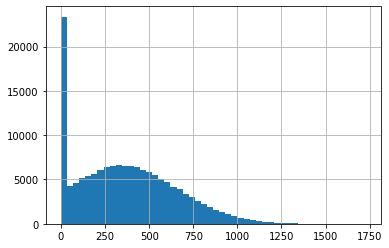

In [21]:
# Комментарий ревьюера 2
temp = internet.copy()
temp['mb_used'].hist(bins = 50)
print('Нулевых интернет-сессий:',round(temp['mb_used'].value_counts().sort_index()[0]/temp['mb_used'].count(),2), '%')

In [22]:
tariffs = pd.read_csv('')

In [23]:
tariffs.info()
print (tariffs.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes
   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3              

В датафрейме tariffs нет ничего, вызывающего вопросы.

### Выводы по результатам предварительного анализа данных

1. Столбцы 'message_date' в датафрейме messages, 'call_date' в calls, 'session_date' в internet, 'churn_date' и 'reg_date' нужно привести к типу datetime.
2. Cтолбец 'Unnamed: 0' в internet нужно удалить.
3. Нужно заполнить пропуски в столбце 'churn_date' в users значением 31 декабря 2018 года, полагая, что контракт дейстовал, как минимум до конца 2018 года (а это период нашего анализа).


## Предобработка данных

### Предварительная обработка данных

Удалим столбец 'Unnamed: 0' с использованием метода drop 

In [24]:
internet=internet.drop(columns=['Unnamed: 0'],axis=1)
internet.info ()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [25]:
users['churn_date']=users['churn_date'].fillna('2018-12-31')
print(users.head())

   user_id  age  churn_date         city first_name  last_name    reg_date  \
0     1000   52  2018-12-31    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41  2018-12-31       Москва       Иван       Ежов  2018-11-01   
2     1002   59  2018-12-31  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23  2018-12-31       Москва      Белла   Белякова  2018-08-17   
4     1004   68  2018-12-31  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra  


In [26]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     500 non-null    int64         
 1   age         500 non-null    int64         
 2   churn_date  500 non-null    datetime64[ns]
 3   city        500 non-null    object        
 4   first_name  500 non-null    object        
 5   last_name   500 non-null    object        
 6   reg_date    500 non-null    datetime64[ns]
 7   tariff      500 non-null    object        
dtypes: datetime64[ns](2), int64(2), object(4)
memory usage: 31.4+ KB


In [27]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages.info()
calls.info()
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            123036 non-null  object        
 1   message_date  123036 non-null  datetime64[ns]
 2   user_id       123036 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         202607 non-null  object        
 1   call_date  202607 non-null  datetime64[ns]
 2   duration   202607 non-null  float64       
 3   user_id    202607 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data colu

### Результаты обработки

1. В столбцах 'message_date' в датафрейме messages, 'call_date' в calls, 'session_date' в internet, 'churn_date' и 'reg_date' заменили тип на datetime.
2. Cтолбец 'Unnamed: 0' в internet удален.
3. Заполнили пропуски в столбце 'churn_date' в users значением 31 декабря 2018 года, полагая, что контракт дейстовал, как минимум до конца 2018 года (а это период нашего анализа).

## Расчёты и добавление результатов в таблицы. Создание дополнительных таблиц.

### План работы

1. На основании данных из таблицы messages нам нужно получить таблицу, содержащую id пользователей и данные о количестве сообщений по месяцам.
2. На основании данных из таблицы calls нам нужно получить таблицу, содержащую id пользователей и данные о количестве использованных минут по месяцам. При этом помним, что данные о количестве минут каждого разговора округляются в большую сторону. Данные, где длительность 0.0 не учитываем. Т.к. это пропущенные звонки, а значит они не тарифицировались.
3. На основании данных из таблицы internet нам нужно получить таблицу, содержащую id пользователей и количество гигабайт по месяцам. При этом помним:
    - 1 Гб это 1024 Мб,
    - суммируются данные по всем сессиям за месяц и округляются до целых Гб в большую сторону.
4. Создать сводную таблицу, куда войдут id пользователей, данные о потраченных минутах, сообщениях и гигабайтах, по видам услуг. Данные о суммарных затратах пользователей по месяцам.


### Обработка таблицы messages

In [28]:
messages['month']=pd.DatetimeIndex(messages['message_date']).month
print (messages.head(20))

         id message_date  user_id  month
0    1000_0   2018-06-27     1000      6
1    1000_1   2018-10-08     1000     10
2    1000_2   2018-08-04     1000      8
3    1000_3   2018-06-16     1000      6
4    1000_4   2018-12-05     1000     12
5    1000_5   2018-06-20     1000      6
6    1000_6   2018-11-19     1000     11
7    1000_7   2018-10-29     1000     10
8    1000_8   2018-06-25     1000      6
9    1000_9   2018-12-18     1000     12
10  1000_10   2018-05-30     1000      5
11  1000_11   2018-07-06     1000      7
12  1000_12   2018-08-20     1000      8
13  1000_13   2018-10-30     1000     10
14  1000_14   2018-09-14     1000      9
15  1000_15   2018-08-28     1000      8
16  1000_16   2018-06-25     1000      6
17  1000_17   2018-06-29     1000      6
18  1000_18   2018-07-07     1000      7
19  1000_19   2018-05-29     1000      5


<font color='DarkBlue'><b>Комментарий ревьюера</b></font><br>
<font color='DarkGreen'>👌 Хорошо, добавили колонку с категорией месяца.</font>

Используя сводную таблицу с индексами по столбцам 'user_id', 'month' посчитаем количество значений, например по id. Далее уберем мультииндекс, используя reset_index(). Затем удалим лишние столбцы.

In [29]:
messages_aggregated=messages.pivot_table(index=['user_id', 'month'], aggfunc='count')
messages_aggregated=messages_aggregated.reset_index()
messages_aggregated ['mes_count']=messages_aggregated ['message_date']
messages_aggregated=messages_aggregated.drop(columns=['id','message_date'],axis=1)
print (messages_aggregated.head(20))

    user_id  month  mes_count
0      1000      5         22
1      1000      6         60
2      1000      7         75
3      1000      8         81
4      1000      9         57
5      1000     10         73
6      1000     11         58
7      1000     12         70
8      1002      6          4
9      1002      7         11
10     1002      8         13
11     1002      9          4
12     1002     10         10
13     1002     11         16
14     1002     12         12
15     1003      8         37
16     1003      9         91
17     1003     10         83
18     1003     11         94
19     1003     12         75


### Обработка таблицы calls

Вставим столбец с номером месяца, когда проводился звонок, а также выполним округление минут по каждому звонку, используя np.ceil()

In [30]:
calls['month']=pd.DatetimeIndex(calls['call_date']).month
calls['duration_rounded']=np.ceil(calls['duration'])
print (calls.head(20))

         id  call_date  duration  user_id  month  duration_rounded
0    1000_0 2018-07-25      0.00     1000      7               0.0
1    1000_1 2018-08-17      0.00     1000      8               0.0
2    1000_2 2018-06-11      2.85     1000      6               3.0
3    1000_3 2018-09-21     13.80     1000      9              14.0
4    1000_4 2018-12-15      5.18     1000     12               6.0
5    1000_5 2018-11-02      0.00     1000     11               0.0
6    1000_6 2018-10-18      0.00     1000     10               0.0
7    1000_7 2018-08-22     18.31     1000      8              19.0
8    1000_8 2018-09-15     18.44     1000      9              19.0
9    1000_9 2018-08-15      0.00     1000      8               0.0
10  1000_10 2018-08-22      5.03     1000      8               6.0
11  1000_11 2018-05-28     18.82     1000      5              19.0
12  1000_12 2018-07-05      2.02     1000      7               3.0
13  1000_13 2018-09-29      7.15     1000      9              

Создадим сводную таблицу с индексацией по 'user_id', 'month' и суммой по столбцу 'duration_rounded'. Уберем мультииндекс. И переименуем итоговый столбец в 'calls_time_m'

In [31]:
calls_aggregated=calls.pivot_table(index=['user_id', 'month'],values='duration_rounded', aggfunc='sum')
calls_aggregated=calls_aggregated.reset_index()
calls_aggregated = calls_aggregated.rename(columns={'duration_rounded': 'calls_time_m'})
print (calls_aggregated.head(20))

    user_id  month  calls_time_m
0      1000      5         159.0
1      1000      6         172.0
2      1000      7         340.0
3      1000      8         408.0
4      1000      9         466.0
5      1000     10         350.0
6      1000     11         338.0
7      1000     12         333.0
8      1001     11         430.0
9      1001     12         414.0
10     1002      6         117.0
11     1002      7         214.0
12     1002      8         289.0
13     1002      9         206.0
14     1002     10         212.0
15     1002     11         243.0
16     1002     12         236.0
17     1003      8         380.0
18     1003      9         961.0
19     1003     10         855.0


### Обработка таблицы internet

Вставим столбец с номером месяца, когда была интернет сессия. Создадим сводную таблицу с индексацией по 'user_id', 'month' и суммой по столбцу 'mb_used'. Уберем мультииндекс. Вставим столбец 'gb_used_m', куда поместим итоговые значения с округлением в большую сторону до Гб (как делает компания).

In [32]:
internet['month']=pd.DatetimeIndex(internet['session_date']).month
internet_aggregated=internet.pivot_table(index=['user_id', 'month'],values='mb_used', aggfunc='sum')
internet_aggregated=internet_aggregated.reset_index()
#internet_aggregated['gb_used_m']=np.ceil(internet_aggregated['mb_used']/1024)
#internet_aggregated=internet_aggregated.drop(columns=['mb_used'],axis=1)
print (internet_aggregated.head(20))

    user_id  month   mb_used
0      1000      5   2253.49
1      1000      6  23233.77
2      1000      7  14003.64
3      1000      8  14055.93
4      1000      9  14568.91
5      1000     10  14702.49
6      1000     11  14756.47
7      1000     12   9817.61
8      1001     11  18429.34
9      1001     12  14036.66
10     1002      6  10856.82
11     1002      7  17580.10
12     1002      8  20319.26
13     1002      9  16691.08
14     1002     10  13888.25
15     1002     11  18587.28
16     1002     12  18113.73
17     1003      8   8565.21
18     1003      9  12468.87
19     1003     10  14768.14


Удалим ставший ненужным столбец 'mb_used'

### Создание сводной таблицы

messages_aggregatedВыполним попарное слияние таблиц internet_aggregated, calls_aggregated и users. 

In [33]:
table_merged_1=internet_aggregated.merge(calls_aggregated, on=['user_id','month'], how='outer') 
table_merged_1.info()
print(table_merged_1.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3214 non-null   int64  
 1   month         3214 non-null   int64  
 2   mb_used       3203 non-null   float64
 3   calls_time_m  3174 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 125.5 KB
   user_id  month   mb_used  calls_time_m
0     1000      5   2253.49         159.0
1     1000      6  23233.77         172.0
2     1000      7  14003.64         340.0
3     1000      8  14055.93         408.0
4     1000      9  14568.91         466.0
5     1000     10  14702.49         350.0
6     1000     11  14756.47         338.0
7     1000     12   9817.61         333.0
8     1001     11  18429.34         430.0
9     1001     12  14036.66         414.0


In [34]:
table_merged_2=table_merged_1.merge(messages_aggregated, on=['user_id','month'], how='outer')
table_merged_2.info()
print(table_merged_2.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3214 non-null   int64  
 1   month         3214 non-null   int64  
 2   mb_used       3203 non-null   float64
 3   calls_time_m  3174 non-null   float64
 4   mes_count     2717 non-null   float64
dtypes: float64(3), int64(2)
memory usage: 150.7 KB
   user_id  month   mb_used  calls_time_m  mes_count
0     1000      5   2253.49         159.0       22.0
1     1000      6  23233.77         172.0       60.0
2     1000      7  14003.64         340.0       75.0
3     1000      8  14055.93         408.0       81.0
4     1000      9  14568.91         466.0       57.0
5     1000     10  14702.49         350.0       73.0
6     1000     11  14756.47         338.0       58.0
7     1000     12   9817.61         333.0       70.0
8     1001     11  18429.34         430.0        NaN
9     1001 

In [35]:
table_aggregated=table_merged_2.merge(users, on='user_id', how='outer')

table_aggregated=table_aggregated.drop(columns=['age','churn_date', 'first_name', 'last_name', 'reg_date'],axis=1)
table_aggregated.info()
print(table_aggregated.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3215
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3216 non-null   int64  
 1   month         3214 non-null   float64
 2   mb_used       3203 non-null   float64
 3   calls_time_m  3174 non-null   float64
 4   mes_count     2717 non-null   float64
 5   city          3216 non-null   object 
 6   tariff        3216 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 201.0+ KB
   user_id  month   mb_used  calls_time_m  mes_count       city tariff
0     1000    5.0   2253.49         159.0       22.0  Краснодар  ultra
1     1000    6.0  23233.77         172.0       60.0  Краснодар  ultra
2     1000    7.0  14003.64         340.0       75.0  Краснодар  ultra
3     1000    8.0  14055.93         408.0       81.0  Краснодар  ultra
4     1000    9.0  14568.91         466.0       57.0  Краснодар  ultra
5     1000   10.0

Из полученной после слияний таблицы удалим столбцы 'age','churn_date', 'first_name', 'last_name', 'reg_date', которые нам не нужны далее. Кроме того, видим, что в таблице появились две дополнительный строки. Это пользователи, которые зарегистрировались, но не пользовались услугами. Их удалим, используя метод dropna.

In [36]:
table_aggregated = table_aggregated.dropna(subset=['month']).reset_index(drop=True)
table_aggregated.info()
print(table_aggregated.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3214 non-null   int64  
 1   month         3214 non-null   float64
 2   mb_used       3203 non-null   float64
 3   calls_time_m  3174 non-null   float64
 4   mes_count     2717 non-null   float64
 5   city          3214 non-null   object 
 6   tariff        3214 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 175.9+ KB
   user_id  month   mb_used  calls_time_m  mes_count       city tariff
0     1000    5.0   2253.49         159.0       22.0  Краснодар  ultra
1     1000    6.0  23233.77         172.0       60.0  Краснодар  ultra
2     1000    7.0  14003.64         340.0       75.0  Краснодар  ultra
3     1000    8.0  14055.93         408.0       81.0  Краснодар  ultra
4     1000    9.0  14568.91         466.0       57.0  Краснодар  ultra
5     1000   10.0

In [37]:
# Комментарий ревьюера
table_aggregated.user_id.unique().shape 

(498,)

По недостающим данным из столбцов gb_used_m, calls_time_m, mes_count будем исходить из того, что если их за какой-то месяц нет, то пользователь соответствующей услугой не пользовался. Заменяем на 0, используя fiilna.

In [38]:
table_aggregated['mb_used']=table_aggregated['mb_used'].fillna(0)
table_aggregated['calls_time_m']=table_aggregated['calls_time_m'].fillna(0)
table_aggregated['mes_count']=table_aggregated['mes_count'].fillna(0)
table_aggregated.info()
print(table_aggregated.head(10))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3214 non-null   int64  
 1   month         3214 non-null   float64
 2   mb_used       3214 non-null   float64
 3   calls_time_m  3214 non-null   float64
 4   mes_count     3214 non-null   float64
 5   city          3214 non-null   object 
 6   tariff        3214 non-null   object 
dtypes: float64(4), int64(1), object(2)
memory usage: 175.9+ KB
   user_id  month   mb_used  calls_time_m  mes_count       city tariff
0     1000    5.0   2253.49         159.0       22.0  Краснодар  ultra
1     1000    6.0  23233.77         172.0       60.0  Краснодар  ultra
2     1000    7.0  14003.64         340.0       75.0  Краснодар  ultra
3     1000    8.0  14055.93         408.0       81.0  Краснодар  ultra
4     1000    9.0  14568.91         466.0       57.0  Краснодар  ultra
5     1000   10.0

Переименуем столбец 'tariff_name' в 'tariff' в таблице tariffs

In [39]:
tariffs = tariffs.rename(columns={'tariff_name': 'tariff'})
print (tariffs)

   messages_included  mb_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff  
0              550         200                3               3  smart  
1             1950         150                1               1  ultra  


In [40]:
# Комментарий ревьюера
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Выполним слияние таблиц table_aggregated с tariffs по столбцу 'tariff' для дальнейешего расчета расходов пользователей по месяцам

In [41]:
table_aggregated_final=table_aggregated.merge(tariffs, on='tariff')
table_aggregated_final.info()
print(table_aggregated_final.head(10))

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   float64
 2   mb_used                3214 non-null   float64
 3   calls_time_m           3214 non-null   float64
 4   mes_count              3214 non-null   float64
 5   city                   3214 non-null   object 
 6   tariff                 3214 non-null   object 
 7   messages_included      3214 non-null   int64  
 8   mb_per_month_included  3214 non-null   int64  
 9   minutes_included       3214 non-null   int64  
 10  rub_monthly_fee        3214 non-null   int64  
 11  rub_per_gb             3214 non-null   int64  
 12  rub_per_message        3214 non-null   int64  
 13  rub_per_minute         3214 non-null   int64  
dtypes: float64(4), int64(8), object(2)
memory usage: 376.6+ 

Составим функцию для расчета расходов пользователей по месяцам. Для последующего применения её в строке к всему датафрейму

In [42]:
def extra (data):
    # проверка условия перерасхода интернет траффика и перевод разницы в ГБ
    if (data['mb_used']-data['mb_per_month_included'])>0:
        extra_Gb=(data['mb_used']-data['mb_per_month_included'])/1024
    else:
        extra_Gb=0
    extra_Gb = math.ceil(extra_Gb)
    # проверка условия перерасхода лимита по звонкам
    if (data['calls_time_m']-data['minutes_included'])>0:
        extra_min=data['calls_time_m']-data['minutes_included']
    else:
        extra_min=0
    # проверка условия перерасхода количества сообщений
    if (data['mes_count']-data['messages_included'])>0:
        extra_mes=data['mes_count']-data['messages_included']
    else:
        extra_mes=0
    # расчет доплат по перерасходам и основной тариф. Возвращаем полученное значение
    return extra_Gb*data['rub_per_gb']+ extra_min*data['rub_per_minute']+ extra_mes*data['rub_per_message']+data['rub_monthly_fee']
    
table_aggregated_final['revenue'] = table_aggregated_final.apply(extra, axis=1)


In [43]:
table_aggregated_final.info()
table_aggregated_final.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                3214 non-null   int64  
 1   month                  3214 non-null   float64
 2   mb_used                3214 non-null   float64
 3   calls_time_m           3214 non-null   float64
 4   mes_count              3214 non-null   float64
 5   city                   3214 non-null   object 
 6   tariff                 3214 non-null   object 
 7   messages_included      3214 non-null   int64  
 8   mb_per_month_included  3214 non-null   int64  
 9   minutes_included       3214 non-null   int64  
 10  rub_monthly_fee        3214 non-null   int64  
 11  rub_per_gb             3214 non-null   int64  
 12  rub_per_message        3214 non-null   int64  
 13  rub_per_minute         3214 non-null   int64  
 14  revenue                3214 non-null   float64
dtypes: f

,user_id,month,mb_used,calls_time_m,mes_count,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1251.590230,8.317362,17207.612859,451.244866,38.281269,341.148102,20067.405103,1266.179216,979.060361,184.676416,2.387057,2.387057,1529.076229
std,144.659172,2.905413,7570.958771,241.909978,36.148326,438.044726,7082.491569,1152.749279,645.539596,23.054986,0.922199,0.922199,798.251091
min,1000.000000,1.000000,0.000000,0.000000,0.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,550.000000
25%,1125.000000,6.000000,12491.890000,282.000000,9.000000,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000,750.000000
50%,1253.000000,9.000000,16943.175000,443.000000,30.000000,50.000000,15360.000000,500.000000,550.000000,200.000000,3.000000,3.000000,1653.500000
75%,1378.750000,11.000000,21424.625000,589.000000,57.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,1950.000000
max,1499.000000,12.000000,49745.690000,1673.000000,224.000000,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000,6770.000000


Для удобства дальнейшей обработки уберем из полученной таблицы все данные связанные с описанием тарифов. И далее будем анализировать полученную таблицу.

In [81]:
# Комментарий ревьюера 3
table_aggregated_final.head()

,user_id,month,mb_used,calls_time_m,mes_count,city,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,revenue
0,1000,5.0,2253.49,159.0,22.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0
1,1000,6.0,23233.77,172.0,60.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0
2,1000,7.0,14003.64,340.0,75.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0
3,1000,8.0,14055.93,408.0,81.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0
4,1000,9.0,14568.91,466.0,57.0,Краснодар,ultra,1000,30720,3000,1950,150,1,1,1950.0


In [44]:
table_sfinal=table_aggregated_final.drop(columns=['messages_included','mb_per_month_included', 'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute' ],axis=1)
table_sfinal['month'] = table_sfinal['month'].astype('int')
table_sfinal.info()
table_sfinal.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   user_id       3214 non-null   int64  
 1   month         3214 non-null   int64  
 2   mb_used       3214 non-null   float64
 3   calls_time_m  3214 non-null   float64
 4   mes_count     3214 non-null   float64
 5   city          3214 non-null   object 
 6   tariff        3214 non-null   object 
 7   revenue       3214 non-null   float64
dtypes: float64(4), int64(2), object(2)
memory usage: 226.0+ KB


,user_id,month,mb_used,calls_time_m,mes_count,revenue
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,1251.590230,8.317362,17207.612859,451.244866,38.281269,1529.076229
std,144.659172,2.905413,7570.958771,241.909978,36.148326,798.251091
min,1000.000000,1.000000,0.000000,0.000000,0.000000,550.000000
25%,1125.000000,6.000000,12491.890000,282.000000,9.000000,750.000000
50%,1253.000000,9.000000,16943.175000,443.000000,30.000000,1653.500000
75%,1378.750000,11.000000,21424.625000,589.000000,57.000000,1950.000000
max,1499.000000,12.000000,49745.690000,1673.000000,224.000000,6770.000000


### Результаты расчетов и создания таблицы

1. На основании данных из таблицы messages создана таблица, содержащая id пользователей и данные о количестве сообщений по месяцам.
2. На основании данных из таблицы calls создана таблица, содержащая id пользователей и данные о количестве использованных минут по месяцам. При этом учли, что данные о количестве минут каждого разговора округляются в большую сторону. Данные, где длительность 0.0 не учитывали (но и не удаляли). Т.к. это пропущенные звонки, а значит они не тарифицировались.
3. На основании данных из таблицы internet получена таблица, содержащая id пользователей и количество гигабайт по месяцам.
4. Создана сводная таблица, куда вошли id пользователей, данные о потраченных минутах, сообщениях и гигабайтах, по видам услуг. Данные о суммарных затратах пользователей по месяцам.
5. Для расчета суммарного тарифа составлена функция, где учли, что:
        - 1 Гб это 1024 Мб,
        - суммируются данные по всем интернет-сессиям за месяц и округляются до целых Гб в большую сторону.
4. Сводная таблица очищена от избыточных для дальнейшего анализа столбцов. Данные в 'table_sfinal'.



## Анализ данных.

### Исследования потребностей пользователей на каждом из тарифов в количестве телефонных звонков, сообщений и интернет траффике.

Для исследования данных об времени звонков составим сводную таблицу со средними значениями использованных минут в разбивке по тарифам.

In [45]:
calls_smart_vs_ultra=table_sfinal.pivot_table(index='month',columns = 'tariff',values='calls_time_m', aggfunc='mean')
calls_smart_vs_ultra=calls_smart_vs_ultra.reset_index()
print (calls_smart_vs_ultra)
calls_smart_vs_ultra.describe()

tariff  month       smart       ultra
0           1  203.852941  428.111111
1           2  298.689655  297.125000
2           3  390.051948  489.648649
3           4  367.133929  458.018182
4           5  387.361702  510.328358
5           6  395.640244  479.702381
6           7  408.353234  545.791209
7           8  421.468085  510.775701
8           9  428.611538  539.443478
9          10  426.136054  558.081301
10         11  435.265823  541.380597
11         12  478.560831  592.805755


tariff,month,smart,ultra
count,12.000000,12.000000,12.000000
mean,6.500000,386.760499,495.934310
std,3.605551,72.262004,77.450072
min,1.000000,203.852941,297.125000
25%,3.750000,382.304759,474.281331
50%,6.500000,401.996739,510.552030
75%,9.250000,426.754925,542.483250
max,12.000000,478.560831,592.805755


In [46]:
calls_smart_vs_ultra_t=table_sfinal.pivot_table(index='tariff',values='calls_time_m', aggfunc='mean')
calls_smart_vs_ultra_t

,calls_time_m
tariff,
smart,417.934948
ultra,526.623350


После использования describe() и анализируя диаграмму видим, что среднее количество минут, используемых в тариф ультра больше примерно на 25-30%.

<AxesSubplot:xlabel='month'>

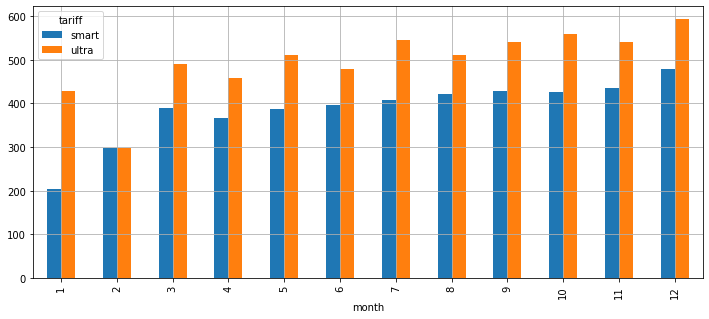

In [47]:
calls_smart_vs_ultra.plot(kind='bar',y= ['smart','ultra'], x='month',grid=True, figsize=(12, 5))

<AxesSubplot:xlabel='month'>

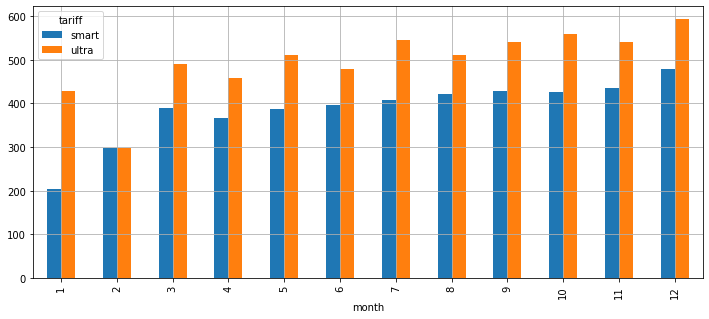

In [48]:
calls_smart_vs_ultra.plot(kind='bar',y= ['smart','ultra'], x='month',grid=True, figsize=(12, 5))

[Text(0.5, 1.0, 'Название графика'),
 Text(0.5, 0, 'Подпись оси Х'),
 Text(0, 0.5, 'Подпись оси Y')]

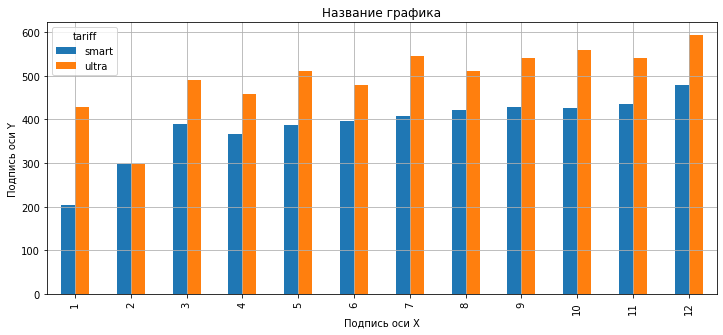

In [49]:
# Комментарий ревьюера 2
(calls_smart_vs_ultra.plot(kind='bar',y= ['smart','ultra'], x='month',grid=True, figsize=(12, 5))
 .set(title = 'Название графика', xlabel = 'Подпись оси Х', ylabel = 'Подпись оси Y'))

<AxesSubplot:xlabel='month'>

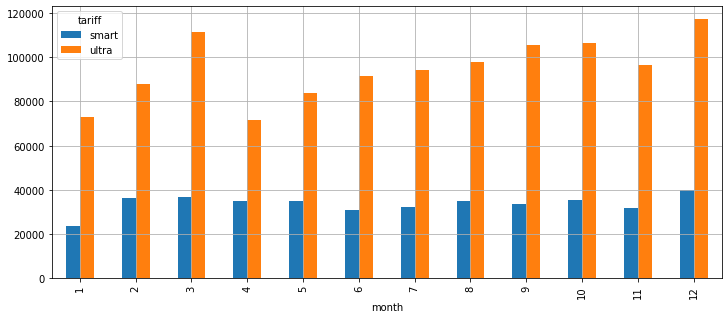

In [50]:
(
table_sfinal.pivot_table(index='month',columns = 'tariff',values='calls_time_m', aggfunc='var')
    .plot(kind='bar',y= ['smart','ultra'],grid=True, figsize=(12, 5))
)

Анализ дисперсии и среднеквадратичного отклонения по диаграммам показывает, что разброс количества используемых минут по тарифу Ультра больше, чем по тарифу Смарт.

<AxesSubplot:xlabel='month'>

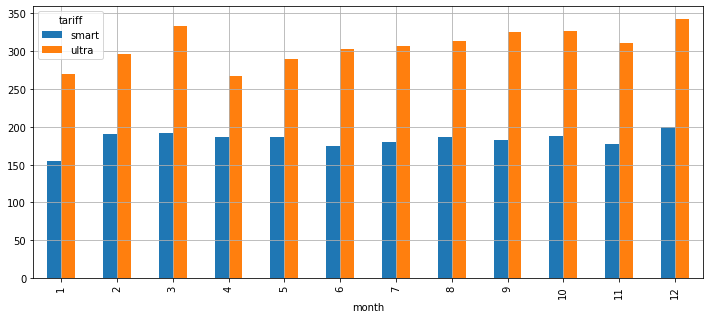

In [51]:
(
table_sfinal.pivot_table(index='month',columns = 'tariff',values='calls_time_m', aggfunc='std')
    .plot(kind='bar',y= ['smart','ultra'],grid=True, figsize=(12, 5))
)

In [52]:
internet_smart_vs_ultra=table_sfinal.pivot_table(index='month',columns = 'tariff',values='mb_used', aggfunc='mean')
internet_smart_vs_ultra=internet_smart_vs_ultra.reset_index()
print (internet_smart_vs_ultra)

tariff  month         smart         ultra
0           1   8513.717647  13140.681111
1           2  11597.054310  11775.937500
2           3  15104.159091  17535.550270
3           4  13462.180625  16828.134364
4           5  15805.184326  19363.152985
5           6  15794.647988  18924.939286
6           7  15743.150348  20495.665165
7           8  16610.720085  19576.054673
8           9  16303.578808  19204.277130
9          10  16757.122891  20045.337317
10         11  16895.696646  19786.812463
11         12  18113.662047  21793.172590


In [53]:
internet_smart_vs_ultra_t=table_sfinal.pivot_table(index='tariff',values='calls_time_m', aggfunc='sum')
internet_smart_vs_ultra_t

,calls_time_m
tariff,
smart,931577.0
ultra,518724.0


После использования describe() и анализируя диаграмму видим, что среднее количество траффика, используемого в тарифе ультра больше примерно на 20-25%.

<AxesSubplot:xlabel='month'>

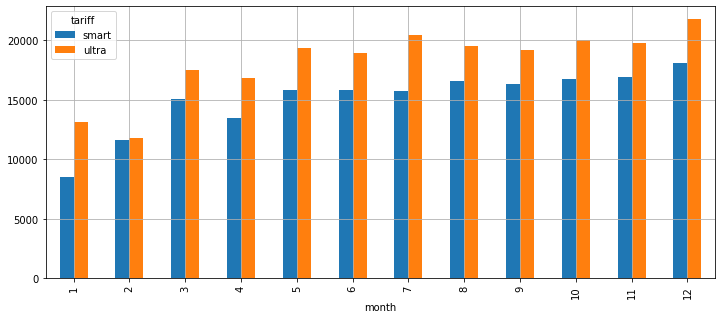

In [54]:
internet_smart_vs_ultra.plot(kind='bar', y= ['smart','ultra'],x='month',grid=True, figsize=(12, 5))

<AxesSubplot:xlabel='month'>

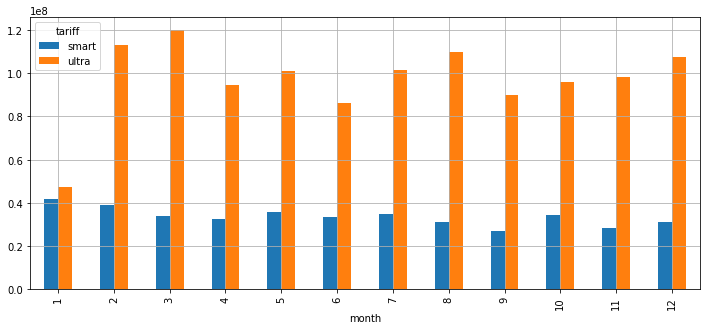

In [55]:
(
table_sfinal.pivot_table(index='month',columns = 'tariff',values='mb_used', aggfunc='var')
    .plot(kind='bar',y= ['smart','ultra'],grid=True, figsize=(12, 5))
)

Анализ дисперсии и среднеквадратичного отклонения по диаграммам показывает, что разброс количества используемых минут по тарифу Ультра больше, чем по тарифу Смарт.

<AxesSubplot:xlabel='month'>

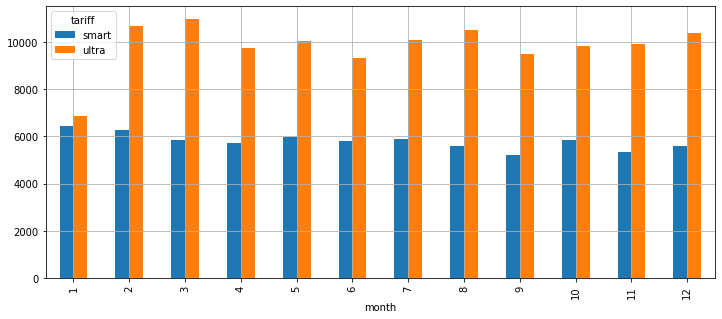

In [56]:
(
table_sfinal.pivot_table(index='month',columns = 'tariff',values='mb_used', aggfunc='std')
    .plot(kind='bar',y= ['smart','ultra'],grid=True, figsize=(12, 5))
)

In [57]:
messages_smart_vs_ultra=table_sfinal.pivot_table(index='month',columns = 'tariff',values='mes_count', aggfunc='mean')
messages_smart_vs_ultra=messages_smart_vs_ultra.reset_index()
print (messages_smart_vs_ultra)

tariff  month      smart      ultra
0           1  18.235294  33.777778
1           2  24.086207  21.958333
2           3  31.857143  32.297297
3           4  30.741071  31.563636
4           5  33.773050  37.850746
5           6  33.402439  41.726190
6           7  33.751244  49.846154
7           8  33.638298  48.439252
8           9  33.638462  52.286957
9          10  33.765306  58.430894
10         11  34.075949  55.791045
11         12  35.994065  60.611511


После использования describe() и анализируя диаграмму видим, что среднее сообщений, отправляемых  в тарифе ультра до мая было сравнимо со средним количеством сообщений в тарифе Смарт. Во второй половине года среднее количество сообщений в тарифе Ультра начало расти и к декабрю стало больше более чем на 80%.

<AxesSubplot:xlabel='month'>

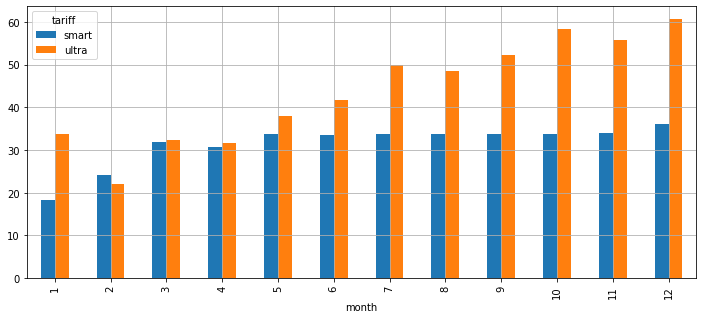

In [58]:
messages_smart_vs_ultra.plot(kind='bar', y= ['smart','ultra'],x='month',grid=True, figsize=(12, 5))

<AxesSubplot:xlabel='month'>

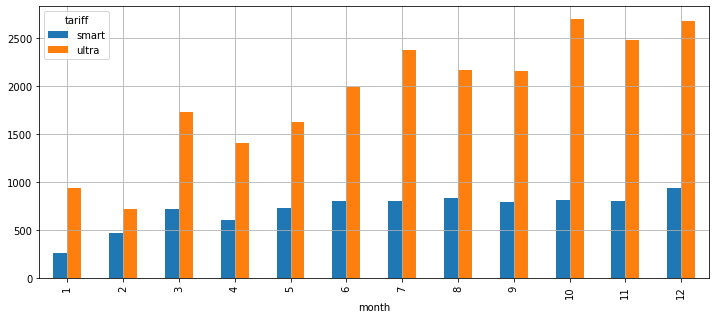

In [59]:
(
table_sfinal.pivot_table(index='month',columns = 'tariff',values='mes_count', aggfunc='var')
    .plot(kind='bar',y= ['smart','ultra'],grid=True, figsize=(12, 5))
)

Анализ дисперсии и среднеквадратичного отклонения по диаграммам показывает, что разброс количества сообщений по тарифу Ультра больше, чем по тарифу Смарт.

<AxesSubplot:xlabel='month'>

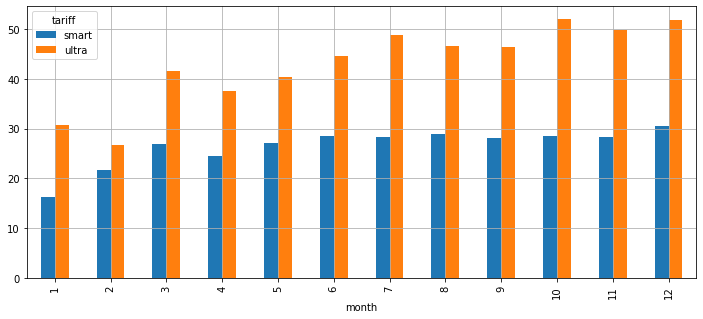

In [60]:
(
table_sfinal.pivot_table(index='month',columns = 'tariff',values='mes_count', aggfunc='std')
    .plot(kind='bar',y= ['smart','ultra'],grid=True, figsize=(12, 5))
)

Ниже построим гистограммы, показывающие разброс средних значений по количеству минут, интернет-траффику и количеству сообщений. Их анализ подтверждает тезис о том, что пользователи тарифа Ультра используют больше ресурсов. В среднем не менее, чем на 20%. Т.е. создают большую нагрузку на инфраструктуру оператора.

array([[<AxesSubplot:title={'center':'smart'}>,
        <AxesSubplot:title={'center':'ultra'}>]], dtype=object)

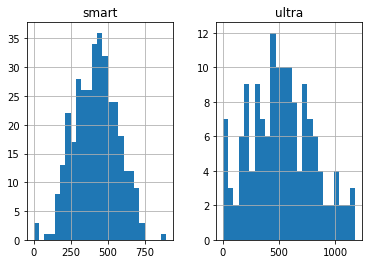

In [61]:
table_sfinal.pivot_table(index = 'user_id',columns=['tariff'], values='calls_time_m', aggfunc='mean').hist(bins=25)

array([[<AxesSubplot:title={'center':'smart'}>,
        <AxesSubplot:title={'center':'ultra'}>]], dtype=object)

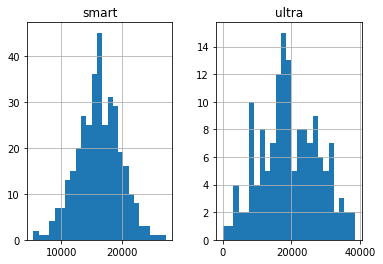

In [62]:
table_sfinal.pivot_table(index = 'user_id',columns=['tariff'], values='mb_used', aggfunc='mean').hist(bins=25)

array([[<AxesSubplot:title={'center':'smart'}>,
        <AxesSubplot:title={'center':'ultra'}>]], dtype=object)

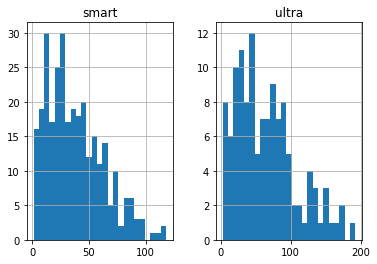

In [63]:
table_sfinal.query('mes_count!=0').pivot_table(index = 'user_id',columns=['tariff'], values='mes_count', aggfunc='mean').hist(bins=25)

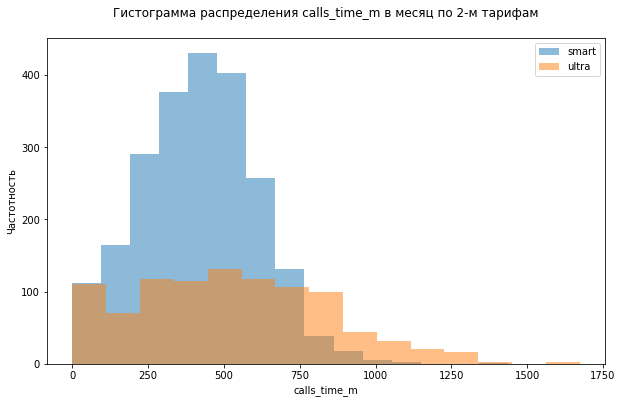

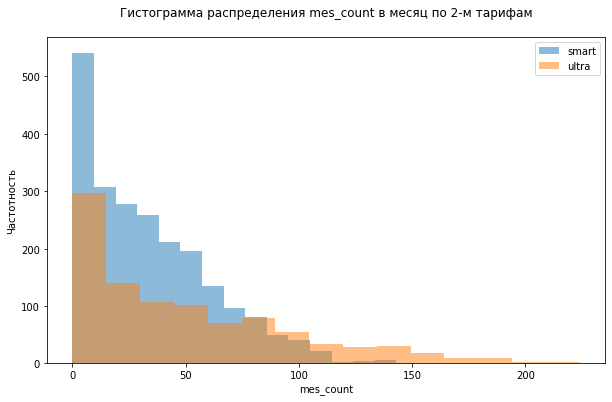

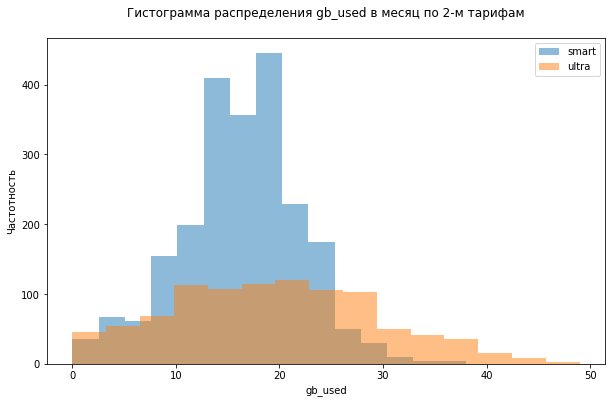

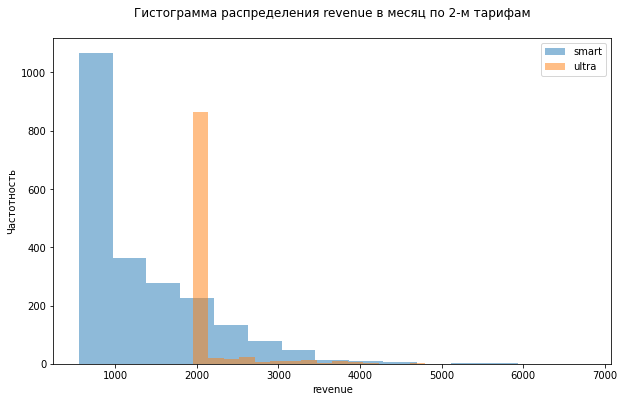

In [85]:
# Комментарий ревьюера 3
# Лень названия колонок переделывать в нормальный текст
import matplotlib.pyplot as plt
temp = table_aggregated_final.copy()
temp['gb_used'] = np.ceil(temp['mb_used'] / 1024)

col = ['calls_time_m', 'mes_count', 'gb_used', 'revenue']
for col_l in col:
    plt.figure(figsize=(10, 6))
    temp[col_l][temp['tariff'] == 'smart'].plot(kind='hist', alpha=0.5, bins=15)
    temp[col_l][temp['tariff'] == 'ultra'].plot(kind='hist', alpha=0.5, bins=15)
    plt.title('Гистограмма распределения '+ col_l +' в месяц по 2-м тарифам'+ "\n")
    plt.xlabel(col_l)
    plt.ylabel('Частотность')
    plt.legend(['smart', 'ultra'])
    plt.show()

In [64]:
revenue_year_per_month=table_sfinal.pivot_table(index='month',columns = 'tariff',values='revenue', aggfunc='sum')
revenue_year_per_month=revenue_year_per_month.reset_index()
messages_smart_vs_ultra

tariff,month,smart,ultra
0,1,18.235294,33.777778
1,2,24.086207,21.958333
2,3,31.857143,32.297297
3,4,30.741071,31.563636
4,5,33.773050,37.850746
5,6,33.402439,41.726190
6,7,33.751244,49.846154
7,8,33.638298,48.439252
8,9,33.638462,52.286957
9,10,33.765306,58.430894


<AxesSubplot:xlabel='month'>

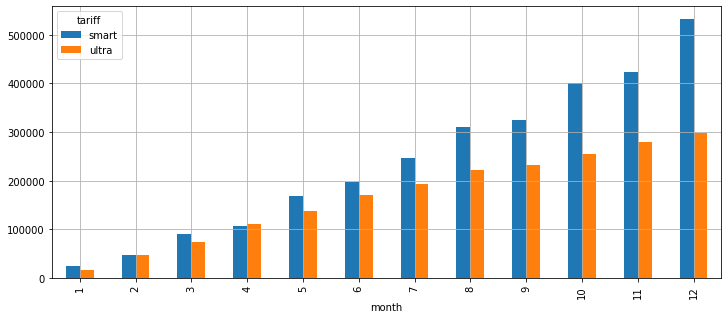

In [65]:
revenue_year_per_month.plot(kind='bar',y= ['smart','ultra'], x='month',grid=True, figsize=(12, 5))

In [66]:
revenue_smart_vs_ultra_t=table_sfinal.pivot_table(index='tariff',values='revenue', aggfunc='sum')
revenue_smart_vs_ultra_t

,revenue
tariff,
smart,2875351.0
ultra,2039100.0


### Выводы.

1. Пользователи тарифа Ультра используют больше минут разговора, интернет-траффика и сообщений в среднем по месяцу на 20-30%.
2. Разброс величин по тарифу Ультра больше, чем по тарифу Смарт.
3. Пользователи  тарифа Ультра создают большую нагрузку на инфраструктуру оператора в расчете на человека на 20-30%.
4. Пользователи тарифа Смарт в общей сложности приносят в 1.45 раз больше выручки за год.

## Проверка гипотез.

### Проверка гипотезы о том, что средняя выручка по тарифам отличается.

Для начала небольшая иллюстрация. Построим гистограмму распределения выручки в зависимости от тарифа. Сразу интересно. По тарифу Ультру основное количество пользователей платит исключительно ежемесячный платеж (выброс до 2000 руб.). А вот по тарифу Смарт выручка распределена более равномерно вокруг величины 2.000 рублей.

array([[<AxesSubplot:title={'center':'smart'}>,
        <AxesSubplot:title={'center':'ultra'}>]], dtype=object)

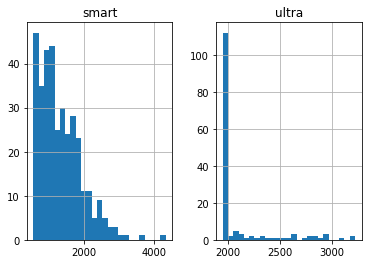

In [67]:
table_sfinal.pivot_table(index = 'user_id',columns=['tariff'], values='revenue', aggfunc='mean').hist(bins=25)

Построим сводную таблицу со средними значениями по выручке в группировке по пользователям-месяцам.

In [68]:
revenue_smart_vs_ultra=table_sfinal.pivot_table(index=['user_id','month'],columns = 'tariff',values='revenue', aggfunc='mean')
revenue_smart_vs_ultra.info()
revenue_smart_vs_ultra.describe()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 3214 entries, (1000, 5) to (1499, 12)
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   smart   2229 non-null   float64
 1   ultra   985 non-null    float64
dtypes: float64(2)
memory usage: 63.7 KB


tariff,smart,ultra
count,2229.000000,985.000000
mean,1289.973531,2070.152284
std,818.404367,376.187114
min,550.000000,1950.000000
25%,550.000000,1950.000000
50%,1023.000000,1950.000000
75%,1750.000000,1950.000000
max,6770.000000,4800.000000


Составим отдельные фреймы для тарифов Смарт и Ультра и удалим из них ячейки с пустыми значениями.

In [69]:
total_smart=revenue_smart_vs_ultra['smart']
total_smart=total_smart.dropna()
total_smart.describe()

count    2229.000000
mean     1289.973531
std       818.404367
min       550.000000
25%       550.000000
50%      1023.000000
75%      1750.000000
max      6770.000000
Name: smart, dtype: float64

In [70]:
total_ultra=revenue_smart_vs_ultra['ultra']
total_ultra=total_ultra.dropna()
total_ultra.describe()

count     985.000000
mean     2070.152284
std       376.187114
min      1950.000000
25%      1950.000000
50%      1950.000000
75%      1950.000000
max      4800.000000
Name: ultra, dtype: float64

Исследуем нулевую гипотезу о том, что средняя выручка по тарифам Смарт и Ультра не различаются. Альтернативная гипотеза, что они отличаются. Зададим уровень значимости (pvalue) в 0.01. 

In [71]:
results = st.ttest_ind(
    total_smart, 
    total_ultra)
if results.pvalue<0.01:
    print ('Средняя выручка по тарифам Смарт и Ультра не различаются. pvalue = ',results.pvalue)
else:
    print ('Средняя выручка по тарифам Смарт и Ультра различаются. pvalue = ',results.pvalue)
print (results)

Средняя выручка по тарифам Смарт и Ультра не различаются. pvalue =  1.4229814360764067e-160
Ttest_indResult(statistic=-28.611056741704818, pvalue=1.4229814360764067e-160)


Гипотеза подтверждена. Средняя выручка по тарифам не отличается.

### Проверка гипотезы о том, что выручка в Москве и в остальных городах отличаются.

Проверим гипотезу о различии в средней выручке в Москве и других городах. Для этого сделаем две выборки Москва и неМосква и выделим из них столбцы с выручкой. 

In [72]:
revenue_moscow_table = table_sfinal.query('city=="Москва"')
revenue_moscow= revenue_moscow_table['revenue']
revenue_moscow.describe()

count     611.000000
mean     1546.713584
std       752.088071
min       550.000000
25%       780.500000
50%      1750.000000
75%      1950.000000
max      5321.000000
Name: revenue, dtype: float64

In [73]:
revenue_non_moscow_table = table_sfinal.query('city!="Москва"')
revenue_non_moscow= revenue_non_moscow_table['revenue']
revenue_non_moscow.describe()

count    2603.000000
mean     1524.936227
std       808.787752
min       550.000000
25%       750.000000
50%      1583.000000
75%      1950.000000
max      6770.000000
Name: revenue, dtype: float64

In [74]:
results_city = st.ttest_ind(
    revenue_moscow, 
    revenue_non_moscow)
print (results_city)

Ttest_indResult(statistic=0.606816942705698, pvalue=0.5440152911670224)


Исследуем нулевую гипотезу о том, что средняя выручка в Москве и других городах не различаются. Альтернативная гипотеза, что они отличаются. Зададим уровень значимости (pvalue) в 0.01. 

In [75]:
if results_city.pvalue<0.01:
    print ('Средняя выручка в Москве и других городах не различаются. pvalue = ',results_city.pvalue)
else:
    print ('Средняя выручка  в Москве и других городах различаются. pvalue = ',results_city.pvalue)
print (results_city)

Средняя выручка  в Москве и других городах различаются. pvalue =  0.5440152911670224
Ttest_indResult(statistic=0.606816942705698, pvalue=0.5440152911670224)


In [76]:
if results_city.pvalue<0.05:
    print ('Средняя выручка в Москве и других городах не различаются. pvalue = ',results_city.pvalue)
else:
    print ('Средняя выручка  в Москве и других городах различаются. pvalue = ',results_city.pvalue)
print (results_city)

Средняя выручка  в Москве и других городах различаются. pvalue =  0.5440152911670224
Ttest_indResult(statistic=0.606816942705698, pvalue=0.5440152911670224)


Нулевая гипотеза опровергнута. Выручка в Москве и других городах значительно различаются.

### Выводы.

1. Проведены исследования показателей используемых минут, интернет-трафика и сообщений. Установлено:
    - пользователи тарифа Ультра используют ресурсы в среднем не менее чем на 20% более активно, т.е. создают пропорционально большую нагрузку на оборудование оператора.
    - разброс величин значений использования ресурсов по тарифу Ультра также больше.
    - к концу года пользователи тарифа Ультра начали использовать значительно больше сообщений.
2. Гипотеза о том, что средняя выручка по тарифам Ультра и Смарт не отличается подтверждена.
3. Средняя выручка в Москве и других городах различаются.

## Общие выводы.

1. В ходе исследования были открыты и исследованы исходные файлы. В ходе предобработки:
    - Столбцы 'message_date' в датафрейме messages, 'call_date' в calls, 'session_date' в internet, 'churn_date' и 'reg_date' приведены к типу datetime.
    - Cтолбец 'Unnamed: 0' в internet удалён.
    - Заполнили пропуски в столбце 'churn_date' в users значением 31 декабря 2018 года, полагая, что контракт дейстовал, как минимум до конца 2018 года (а это период нашего анализа).
    
2. На этапе расчетов:
    - Создана сводная таблица, куда вошли id пользователей, данные о потраченных минутах, сообщениях и гигабайтах, по видам услуг. Данные о суммарных затратах пользователей по месяцам.
    - Для расчета суммарного тарифа составлена функция, где учли, что:
        - 1 Гб это 1024 Мб,
        - суммируются данные по всем интернет-сессиям за месяц и округляются до целых Гб в большую сторону.
    - Сводная таблица очищена от избыточных для дальнейшего анализа столбцов. Данные в 'table_sfinal'.
    
3. На этапе исследований устновлено:
    - Пользователи тарифа Ультра используют больше минут разговора, интернет-траффика и сообщений в среднем по месяцу на 20-30%.
    - Разброс величин по тарифу Ультра больше, чем по тарифу Смарт.
    - Пользователи тарифа Ультра создают большую нагрузку на инфраструктуру оператора в расчете на человека на 20-30%.
    
4. На этапе статистического анализа:
    - Проведены исследования показателей используемых минут, интернет-трафика и сообщений. Установлено:
        - пользователи тарифа Ультра используют ресурсы в среднем не менее чем на 20% более активно, т.е. создают пропорционально большую нагрузку на оборудование оператора.
        - разброс величин значений использования ресурсов по тарифу Ультра также больше.
        - к концу года пользователи тарифа Ультра начали использовать значительно больше сообщений.
    - Гипотеза о том, что средняя выручка по тарифам Ультра и Смарт не отличается подтверждена.
    - Средняя выручка в Москве и других городах различаются.

5. Пользователи тарифа Ультра создают большую удельную нагрузку на оборудование оператора (от 20%). При этом средняя выручка по тарифам сравнима. Поэтому более перспективным для оператора является вложение средств в продвижение тарифа Смарт.
6. Пользователи тарифа Ультра в целом по году принесли в 1.45 раза больше выручки.

## Самый глобальный вывод.

Тариф Смарт более выгоден для компании, так как:
1. Пользователи тарифа приносят в 1.45 раза большую выручку в течение года.
2. Пользователи тарифа Ультра создают большую удельную нагрузку на оборудование оператора (от 20%). При этом средняя выручка по тарифам сравнима. Поэтому более перспективным для оператора является вложение средств в продвижение тарифа Смарт.